# Great Energy Predictor - Featurization
#### Hosted by: ASHRAE
##### Source: https://www.kaggle.com/c/ashrae-energy-prediction

## Section I: Dependencies and Data

### Dependencies

In [1]:
%matplotlib inline

import gc
import holidays
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from feature_engine.categorical_encoders import RareLabelCategoricalEncoder as RareEncoder, \
                                                MeanCategoricalEncoder as MeanEncoder, \
                                                OrdinalCategoricalEncoder as OrdinalEncoder

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression, RFE, SelectFromModel, SelectKBest, SelectPercentile
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import src.utils as udf

In [2]:
# Dataframe settings
pd.set_option('display.max_columns', 50)

# Plot settings
sns.set(rc={'figure.figsize': (15, 3),
            'font.size': 15})

### Data

In [3]:
# Data path
data_path = '../data/from_prep/'

In [4]:
# Meter data
meter = pd.read_pickle(data_path + 'meter.pkl')
meter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18205342 entries, 72 to 20216099
Data columns (total 11 columns):
 #   Column         Dtype         
---  ------         -----         
 0   building_id    uint16        
 1   meter          uint8         
 2   timestamp      datetime64[ns]
 3   meter_reading  float32       
 4   site_id        uint8         
 5   meter_type     object        
 6   dayofyear      uint16        
 7   month          uint8         
 8   day            uint8         
 9   dayofweek      uint8         
 10  hour           uint8         
dtypes: datetime64[ns](1), float32(1), object(1), uint16(2), uint8(6)
memory usage: 659.8+ MB


In [5]:
# Weather data
weather = pd.read_pickle(data_path + 'weather.pkl')
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140544 entries, 0 to 140543
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   site_id             140544 non-null  uint8         
 1   timestamp           140544 non-null  datetime64[ns]
 2   air_temperature     140544 non-null  float32       
 3   dew_temperature     140544 non-null  float32       
 4   sea_level_pressure  140544 non-null  float32       
 5   wind_direction      140544 non-null  uint16        
 6   wind_speed          140544 non-null  float32       
dtypes: datetime64[ns](1), float32(4), uint16(1), uint8(1)
memory usage: 3.6 MB


In [6]:
# Building data
building = pd.read_pickle(data_path + 'building.pkl')
building.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   site_id       1449 non-null   uint8 
 1   building_id   1449 non-null   uint16
 2   primary_use   1449 non-null   object
 3   square_feet   1449 non-null   uint32
 4   year_built    1449 non-null   uint8 
 5   missing_year  1449 non-null   uint8 
dtypes: object(1), uint16(1), uint32(1), uint8(3)
memory usage: 24.2+ KB


In [7]:
del data_path
gc.collect()

55

## Section II: Feature Engineering

### Convert `wind_direction` to Cartesian components

In the weather data, the `wind_direction` was recorded as a compass direction, which is in the polar coordinate system. This won't work in the context of machine learning because the numeric values imply that this feature has an ordinal nature, and that's simply not true. A direction of 300 degrees is not more than a direction of 100 degrees; it's just in a different direction.

In order for machine learning models to be able to interpret `wind_direction` correctly, it needs to be using Cartesian coordinates. We will make this conversion by extracting the x and y components of the direction values, which together would describe the `wind_direction`.

Note: `wind_direction` contains both values of 0 and 360, which are the same direction. But in this case, a `wind_direction` of 0 just means that there was no wind, as evident by the 0 `wind_speed`.

In [8]:
# Extract x and y components from wind_direction
weather = udf.polar_to_cartesian(weather, 'wind_direction')
weather.head(3)

,site_id,timestamp,air_temperature,dew_temperature,sea_level_pressure,wind_speed,wind_direction_x,wind_direction_y
0,0,2016-01-01 00:00:00,19.4,19.4,1019.400024,0.0,0.000000,0.0
1,0,2016-01-01 01:00:00,21.1,21.1,1019.400024,0.0,0.000000,0.0
2,0,2016-01-01 02:00:00,21.1,21.1,1018.799988,1.5,-0.866025,-0.5


### Create a new feature for relative humidity

The weather data contains both `air_temperature` and `dew_temperature`, which are highly correlated. Relative humidity is a weather feature that can be calculated using both `air_temperature` and `dew_temperature`. Relative humidity may effectively replace both by incorporating the information from both features and eliminating the multicollinearity. The calculation for this new feature follows the source below.

We won't be dropping `air_temperature` and `dew_temperature` just yet because we don't actually know which feature will be the most useful in building machine learning models until actually building them.

Source: https://www.weather.gov/media/epz/wxcalc/vaporPressure.pdf

In [9]:
# Add feature for relative humidity
weather['rel_humidity'] = udf.calc_rel_humidity(weather.air_temperature, weather.dew_temperature)
weather.describe()

,site_id,air_temperature,dew_temperature,sea_level_pressure,wind_speed,wind_direction_x,wind_direction_y,rel_humidity
count,140544.000000,140544.000000,140544.000000,140544.000000,140544.000000,140544.000000,1.405440e+05,140544.000000
mean,7.500000,14.356584,7.297376,1016.131287,3.562700,-0.037601,-9.005360e-02,67.503700
std,4.609789,10.669369,9.826284,7.883689,2.334334,0.663424,6.739621e-01,21.754589
min,0.000000,-28.900000,-35.000000,968.200012,0.000000,-1.000000,-1.000000e+00,3.751658
25%,3.750000,7.200000,0.600000,1011.599976,2.100000,-0.642788,-7.660444e-01,52.516804
50%,7.500000,15.000000,8.200000,1016.400024,3.100000,0.000000,-2.449294e-16,71.740288
75%,11.250000,22.200001,14.400000,1020.900024,5.000000,0.500000,5.000000e-01,85.883133
max,15.000000,47.200001,26.100000,1045.500000,19.000000,1.000000,1.000000e+00,119.269371


### Add a boolean indicator for weekends

As seen in the EDA, there was a bit of difference in energy usage between weekdays and weekends for some buildings, especially with electricity meters. It would be useful to have a boolean feature that indicates whether the meter reading was during the weekend. We will create this weekend indicator by checking if the `dayofweek` is 5 (Saturday) or 6 (Sunday).

In [10]:
# Create weekend feature
meter['is_weekend'] = meter.dayofweek.apply(lambda d: int(d in [5, 6])).astype('uint8')
meter.tail(3)

,building_id,meter,timestamp,meter_reading,site_id,meter_type,dayofyear,month,day,dayofweek,hour,is_weekend
20216096,1445,0,2016-12-31 23:00:00,4.825000,15,electricity,366,12,31,5,23,1
20216098,1447,0,2016-12-31 23:00:00,159.574997,15,electricity,366,12,31,5,23,1
20216099,1448,0,2016-12-31 23:00:00,2.850000,15,electricity,366,12,31,5,23,1


### Add a boolean indicator for holidays

Just as with weekends, energy usage is likely different on holidays so we will create a boolean feature that indicates whether the meter reading was during a holiday. In order to do this, we must first label each site with its respective country in order to correctly identify which holidays to use.

In [11]:
# Add country feature
site_countries = {0: 'US', 1: 'UK', 2: 'US', 3: 'US', 4: 'US', 5: 'UK', 6: 'US', 7: 'CA', 
                  8: 'US', 9: 'US', 10: 'US', 11: 'CA', 12: 'IE', 13: 'US', 14: 'US', 15: 'US'}
meter['country'] = meter.site_id.map(site_countries)
meter.head(3)

,building_id,meter,timestamp,meter_reading,site_id,meter_type,dayofyear,month,day,dayofweek,hour,is_weekend,country
72,74,0,2016-01-01,12.603682,0,electricity,1,1,1,4,0,0,US
91,93,0,2016-01-01,15.364478,0,electricity,1,1,1,4,0,0,US
103,105,0,2016-01-01,23.303600,1,electricity,1,1,1,4,0,0,UK


In [12]:
# Holiday dates for each country
US_holidays = holidays.UnitedStates()     # sites 0, 2, 3, 4, 6, 8, 9, 10, 13, 14, 15 
CA_holidays = holidays.Canada()           # sites 7, 11
UK_holidays = holidays.UnitedKingdom()    # sites 1, 5
IE_holidays = holidays.Ireland()          # site 12

In [13]:
# Create holiday featuure
meter['is_holiday'] = meter.apply(lambda r: r.timestamp in eval(r.country + '_holidays'), axis=1).astype('uint8')
meter.head(3)

,building_id,meter,timestamp,meter_reading,site_id,meter_type,dayofyear,month,day,dayofweek,hour,is_weekend,country,is_holiday
72,74,0,2016-01-01,12.603682,0,electricity,1,1,1,4,0,0,US,1
91,93,0,2016-01-01,15.364478,0,electricity,1,1,1,4,0,0,US,1
103,105,0,2016-01-01,23.303600,1,electricity,1,1,1,4,0,0,UK,1


### Group UK and IE into 1 label: EU

Now that the `country` has been used to create the `is_holiday` feature, we can update it in a way that minimizes rare labels. Only 1 site is in Ireland, so Ireland will be grouped with the United Kingdom to make "EU".

In [14]:
# Replace "UK" and "IE" with "EU" in `country`
meter['country'] = meter.country.str.replace(r'UK|IE', 'EU')
meter.country.value_counts()

US    16232087
EU     1602403
CA      370852
Name: country, dtype: int64

In [15]:
del site_countries, US_holidays, CA_holidays, UK_holidays, IE_holidays
gc.collect()

55

## Section III: Data Processing

### Save dataframes

In [16]:
# Create new subdirectory in data directory
output_path = '../data/from_feat/'
udf.mkdir(output_path)

In [17]:
# Save meter data
meter.to_pickle(output_path + 'meter.pkl')
pd.read_pickle(output_path + 'meter.pkl').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18205342 entries, 72 to 20216099
Data columns (total 14 columns):
 #   Column         Dtype         
---  ------         -----         
 0   building_id    uint16        
 1   meter          uint8         
 2   timestamp      datetime64[ns]
 3   meter_reading  float32       
 4   site_id        uint8         
 5   meter_type     object        
 6   dayofyear      uint16        
 7   month          uint8         
 8   day            uint8         
 9   dayofweek      uint8         
 10  hour           uint8         
 11  is_weekend     uint8         
 12  country        object        
 13  is_holiday     uint8         
dtypes: datetime64[ns](1), float32(1), object(2), uint16(2), uint8(8)
memory usage: 833.4+ MB


In [18]:
# Save weather data
weather.to_pickle(output_path + 'weather.pkl')
pd.read_pickle(output_path + 'weather.pkl').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140544 entries, 0 to 140543
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   site_id             140544 non-null  uint8         
 1   timestamp           140544 non-null  datetime64[ns]
 2   air_temperature     140544 non-null  float32       
 3   dew_temperature     140544 non-null  float32       
 4   sea_level_pressure  140544 non-null  float32       
 5   wind_speed          140544 non-null  float32       
 6   wind_direction_x    140544 non-null  float32       
 7   wind_direction_y    140544 non-null  float32       
 8   rel_humidity        140544 non-null  float32       
dtypes: datetime64[ns](1), float32(7), uint8(1)
memory usage: 5.0 MB


In [19]:
# Save building data
building.to_pickle(output_path + 'building.pkl')
pd.read_pickle(output_path + 'building.pkl').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   site_id       1449 non-null   uint8 
 1   building_id   1449 non-null   uint16
 2   primary_use   1449 non-null   object
 3   square_feet   1449 non-null   uint32
 4   year_built    1449 non-null   uint8 
 5   missing_year  1449 non-null   uint8 
dtypes: object(1), uint16(1), uint32(1), uint8(3)
memory usage: 24.2+ KB


### Merge all 3 dataframes into 1

In [20]:
# Merge meter and building data
metr_bldg = pd.merge(meter.drop('site_id', axis=1), building, on='building_id', how='left')
metr_bldg.head(3)

,building_id,meter,timestamp,meter_reading,meter_type,dayofyear,month,day,dayofweek,hour,is_weekend,country,is_holiday,site_id,primary_use,square_feet,year_built,missing_year
0,74,0,2016-01-01,12.603682,electricity,1,1,1,4,0,0,US,1,0,Parking,387638,205,0
1,93,0,2016-01-01,15.364478,electricity,1,1,1,4,0,0,US,1,0,Office,33370,190,0
2,105,0,2016-01-01,23.303600,electricity,1,1,1,4,0,0,EU,1,1,Education,50623,168,1


In [21]:
# Add weather data to the merged data
train = pd.merge(metr_bldg, weather, on=['site_id', 'timestamp'], how='left')
print(train.shape)
train.head(3)

(18205342, 25)


,building_id,meter,timestamp,meter_reading,meter_type,dayofyear,month,day,dayofweek,hour,is_weekend,country,is_holiday,site_id,primary_use,square_feet,year_built,missing_year,air_temperature,dew_temperature,sea_level_pressure,wind_speed,wind_direction_x,wind_direction_y,rel_humidity
0,74,0,2016-01-01,12.603682,electricity,1,1,1,4,0,0,US,1,0,Parking,387638,205,0,19.4,19.4,1019.400024,0.0,0.0,0.000000,100.000000
1,93,0,2016-01-01,15.364478,electricity,1,1,1,4,0,0,US,1,0,Office,33370,190,0,19.4,19.4,1019.400024,0.0,0.0,0.000000,100.000000
2,105,0,2016-01-01,23.303600,electricity,1,1,1,4,0,0,EU,1,1,Education,50623,168,1,3.8,2.4,1020.900024,3.1,-0.5,-0.866025,90.549408


In [22]:
# Reorder columns
cols = ['site_id', 'building_id', 'meter', 'meter_type', 'timestamp', 'meter_reading', 
        'air_temperature', 'dew_temperature', 'rel_humidity', 'sea_level_pressure', 
        'wind_direction_x', 'wind_direction_y', 'wind_speed', 
        'primary_use', 'square_feet', 'year_built', 'missing_year', 'country',
        'dayofyear', 'month', 'day', 'hour', 'dayofweek', 'is_weekend', 'is_holiday']
train = train[cols]
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18205342 entries, 0 to 18205341
Data columns (total 25 columns):
 #   Column              Dtype         
---  ------              -----         
 0   site_id             uint8         
 1   building_id         uint16        
 2   meter               uint8         
 3   meter_type          object        
 4   timestamp           datetime64[ns]
 5   meter_reading       float32       
 6   air_temperature     float32       
 7   dew_temperature     float32       
 8   rel_humidity        float32       
 9   sea_level_pressure  float32       
 10  wind_direction_x    float32       
 11  wind_direction_y    float32       
 12  wind_speed          float32       
 13  primary_use         object        
 14  square_feet         uint32        
 15  year_built          uint8         
 16  missing_year        uint8         
 17  country             object        
 18  dayofyear           uint16        
 19  month               uint8         
 20  

### Split train set by meter type

We saw in the EDA that different meter types had different usage patterns, so we will be splitting the dataset up into 4 parts (one for each meter type) and building a separate model for each meter type.

In [23]:
# Split meter types into separate dataframes
m_types = ['electricity', 'chilledwater', 'steam', 'hotwater']
train_dfs = []
for m in m_types:
    train_df = train[train.meter_type == m].drop(['meter', 'meter_type'], axis=1).copy()
    train_df.to_pickle(output_path + m + '.pkl')
    train_dfs.append(train_df)
    print(f'{m} meter: {train_df.shape}')

electricity meter: (11481619, 23)
chilledwater meter: (3507966, 23)
steam meter: (2296049, 23)
hotwater meter: (919708, 23)


In [24]:
del metr_bldg, cols, m, train_df
gc.collect()

22

## Section IV: Feature Elimination - Electricity Meter

As more than half of the data are meter readings from electricity meters, we will be looking at electricity meters. The processed used here will be followed for the other 3 meter types.

Note: The letter "e" will be appended to variables to indicate that we are working with electricity meter data. For example, the variable data X will be called `Xe` and the target label y will be called `ye`.

### Data split - train, validation, test

The data is being split into 3 sets:
1. Training set - the machine learning model will be trained on this set
2. Validation set - model performance will be evaluated on this set during model tuning
3. Test set - this will be the holdout set for final testing once we have a finished model

We are splitting the data before the model selection process to minimize data leakage, that is, information from the validation or test set leaking into the training data in any way.

In [25]:
# Split data and target for electricity meter data
Xe = train_dfs[0].drop('meter_reading', axis=1).copy()
ye = train_dfs[0]['meter_reading'].copy()
print(Xe.shape, ye.shape)

(11481619, 22) (11481619,)


In [26]:
# Train/val/test split (60/20/20)
Xe_train, Xe_test, ye_train, ye_test = train_test_split(Xe, ye, test_size=0.4, random_state=0)
Xe_val, Xe_test, ye_val, ye_test = train_test_split(Xe_test, ye_test, test_size=0.5, random_state=0)

print('Train set:', Xe_train.shape, ye_train.shape)
print('Validation set:', Xe_val.shape, ye_val.shape)
print('Test set:', Xe_test.shape, ye_test.shape)
Xe_train.head(3)

Train set: (6888971, 22) (6888971,)
Validation set: (2296324, 22) (2296324,)
Test set: (2296324, 22) (2296324,)


,site_id,building_id,timestamp,air_temperature,dew_temperature,rel_humidity,sea_level_pressure,wind_direction_x,wind_direction_y,wind_speed,primary_use,square_feet,year_built,missing_year,country,dayofyear,month,day,hour,dayofweek,is_weekend,is_holiday
11668719,0,26,2016-08-27 01:00:00,26.1,22.799999,82.086754,1015.400024,0.866025,0.500000,3.1,Office,26953,213,0,US,240,8,27,1,5,1,0
15417488,4,593,2016-11-07 18:00:00,18.9,15.000000,78.094246,1020.099976,0.766044,-0.642788,1.5,Education,66203,223,0,US,312,11,7,18,0,0,0
4404673,3,546,2016-04-06 08:00:00,4.4,-5.000000,50.354458,1029.000000,-0.766044,-0.642788,4.6,Public services,400000,179,0,US,97,4,6,8,2,0,0


In [27]:
del Xe, ye
gc.collect()

22

### Rare label categorical encoding
The `primary_use` feature has a total of 16 categories, more than half of which would be considered "rare" in the data. That is, they occur less than a certain threshold (I will use the threshold 5%). This could be a problem for splitting the data because some rare labels may end up in the validation or test set, but not the training set. The model would not know what to do if it has never seen that label before.

To resolve this issue, we will group all these rare categories (any categories with a count less than 5% of the total data) into 1 label called "Rare".

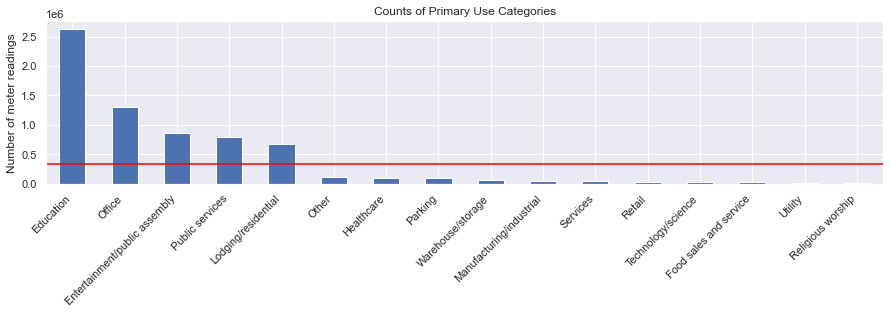

In [28]:
# Inspect `primary_use` categories
udf.plot_rare_cats(Xe_train, 'primary_use')
plt.title('Counts of Primary Use Categories')
plt.ylabel('Number of meter readings')
plt.show()

In [29]:
# Find common categories (has at least 5% of all values)
rarenc = RareEncoder(tol=0.05, variables=['primary_use'])
rarenc.fit(Xe_train)
rarenc.encoder_dict_

{'primary_use': Index(['Education', 'Office', 'Entertainment/public assembly',
        'Public services', 'Lodging/residential'],
       dtype='object')}

In [30]:
# Group rare categories together in all 3 sets
Xe_train = rarenc.transform(Xe_train)
Xe_val = rarenc.transform(Xe_val)
Xe_test = rarenc.transform(Xe_test)

Xe_train.primary_use.value_counts()

Education                        2635696
Office                           1310265
Entertainment/public assembly     871248
Public services                   788379
Lodging/residential               678847
Rare                              604536
Name: primary_use, dtype: int64

### Mean target categorical encoding

The 2 categorical features (`primary_use` and `country`) still need to be encoded numerically. I will be using mean-target categorical encoding instead of one-hot encoding for 2 reasons:
1. To avoid expanding the feature set
2. The different categories showed differrent patterns in energy usage

In [31]:
# Check the mean target of each primary_use and country category
meanenc = MeanEncoder(variables=['primary_use', 'country'])
meanenc.fit(Xe_train, ye_train)
meanenc.encoder_dict_

{'primary_use': {'Education': 240.53219604492188,
  'Entertainment/public assembly': 112.73914337158203,
  'Lodging/residential': 91.4360122680664,
  'Office': 155.53187561035156,
  'Public services': 99.1392593383789,
  'Rare': 111.23979187011719},
 'country': {'CA': 1621.7000732421875,
  'EU': 83.58369445800781,
  'US': 158.88595581054688}}

In [32]:
# Encode primary_use and country using the target mean in both train and validation sets
Xe_train = meanenc.transform(Xe_train)
Xe_val = meanenc.transform(Xe_val)
Xe_test = meanenc.transform(Xe_test)

Xe_train.head(3)

,site_id,building_id,timestamp,air_temperature,dew_temperature,rel_humidity,sea_level_pressure,wind_direction_x,wind_direction_y,wind_speed,primary_use,square_feet,year_built,missing_year,country,dayofyear,month,day,hour,dayofweek,is_weekend,is_holiday
11668719,0,26,2016-08-27 01:00:00,26.1,22.799999,82.086754,1015.400024,0.866025,0.500000,3.1,155.531876,26953,213,0,158.885956,240,8,27,1,5,1,0
15417488,4,593,2016-11-07 18:00:00,18.9,15.000000,78.094246,1020.099976,0.766044,-0.642788,1.5,240.532196,66203,223,0,158.885956,312,11,7,18,0,0,0
4404673,3,546,2016-04-06 08:00:00,4.4,-5.000000,50.354458,1029.000000,-0.766044,-0.642788,4.6,99.139259,400000,179,0,158.885956,97,4,6,8,2,0,0


In [33]:
# Save encoders
joblib.dump(rarenc, '../models/transformers/rare_enc/rare_enc0.pkl')
joblib.dump(meanenc, '../models/transformers/mean_enc/mean_enc0.pkl')

['../models/transformers/mean_enc/mean_enc0.pkl']

### Feature elimination

To start off the feature selection process, we will be looking for the following redundant features to remove:
1. Duplicated features - pairs of features that share the same value for all observations
2. Constant features - features that only have 1 unique value
3. Quasi-constant features - features that have 1 unique value for MOST of their observations (low variance)
    - I will be using a variance threshold of 1%
4. Correlated features - pairs of features with high linear correlation
    - I will be using a correlation threshold of 0.5

In [34]:
# Duplicated features
udf.duplicated_feats(Xe_train)

[]

In [35]:
# Constant and quasi-constant features
udf.constant_feats(Xe_train)

,site_id,building_id,air_temperature,dew_temperature,rel_humidity,sea_level_pressure,wind_direction_x,wind_direction_y,wind_speed,primary_use,square_feet,year_built,missing_year,country,dayofyear,month,day,hour,dayofweek,is_weekend,is_holiday
variance,23.7882,164196,110.158,97.6691,500.101,54.9855,0.453033,0.434259,5.39335,3827.55,1.25552e+10,450.135,0.247385,25842.4,11034.6,11.7582,77.6565,47.9141,3.98948,0.204533,0.0304482
constant,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
quasiconstant,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [36]:
# Correlated features
udf.correlated_feats(Xe_train.corr(), threshold=0.5)

[('site_id', 'building_id', 0.9755979029197416),
 ('air_temperature', 'dew_temperature', 0.7583776706849835),
 ('dayofyear', 'month', 0.9964793970640012),
 ('dayofweek', 'is_weekend', 0.7895943280928298)]

There are no duplicated, constant, or even quasi-constant features. However, there are 4 pairs of correlated features here, all of which have a high correlation constant (much higher than the 0.5 threshold). Let's take a closer look at the feature correlation.

### Correlated features

In [37]:
# Feature correlation
corr = Xe_train.corr()
corr.style.applymap(lambda c: 'color: red; background-color: yellow' if 0.5 < abs(c) < 1 else '')

,site_id,building_id,air_temperature,dew_temperature,rel_humidity,sea_level_pressure,wind_direction_x,wind_direction_y,wind_speed,primary_use,square_feet,year_built,missing_year,country,dayofyear,month,day,hour,dayofweek,is_weekend,is_holiday
site_id,1.000000,0.975598,-0.266264,-0.142972,0.142727,0.013785,-0.013830,-0.023868,-0.001838,-0.047940,0.091691,-0.029709,0.420538,0.050971,-0.027627,-0.027550,-0.002631,0.000017,-0.000549,-0.000857,-0.006036
building_id,0.975598,1.000000,-0.281658,-0.122900,0.188228,0.035044,-0.007265,-0.038698,0.000320,-0.039364,0.083014,-0.073096,0.391887,0.057171,-0.034469,-0.034370,-0.003300,0.000063,-0.000607,-0.001007,-0.005509
air_temperature,-0.266264,-0.281658,1.000000,0.758378,-0.313923,-0.254827,-0.151112,0.099325,-0.081648,-0.025155,-0.004667,0.088366,-0.028603,-0.052601,0.186181,0.186249,0.023970,0.138371,-0.007496,-0.011468,-0.061992
dew_temperature,-0.142972,-0.122900,0.758378,1.000000,0.347672,-0.183457,-0.161781,0.153827,-0.131450,-0.029794,-0.023800,0.034505,-0.023944,-0.065382,0.256583,0.256888,0.023253,-0.003945,-0.007203,-0.013035,-0.047504
rel_humidity,0.142727,0.188228,-0.313923,0.347672,1.000000,0.037711,-0.016174,0.078778,-0.107581,0.009851,-0.031907,-0.066065,-0.036848,-0.025995,0.103408,0.103742,-0.000520,-0.228667,0.000779,-0.001633,0.024441
sea_level_pressure,0.013785,0.035044,-0.254827,-0.183457,0.037711,1.000000,0.122732,0.130119,-0.212517,-0.033162,-0.017610,-0.028948,0.014015,-0.008304,0.156053,0.153810,0.029985,-0.027777,-0.010486,-0.004941,0.076287
wind_direction_x,-0.013830,-0.007265,-0.151112,-0.161781,-0.016174,0.122732,1.000000,-0.065028,0.035617,-0.005793,-0.012516,0.001775,-0.039387,0.019840,0.020377,0.022363,-0.025007,-0.021483,-0.003141,-0.013577,0.015050
wind_direction_y,-0.023868,-0.038698,0.099325,0.153827,0.078778,0.130119,-0.065028,1.000000,-0.197359,-0.036405,0.012290,0.052119,0.043226,-0.001903,0.032260,0.031761,0.008156,-0.042003,-0.010180,-0.004557,-0.002674
wind_speed,-0.001838,0.000320,-0.081648,-0.131450,-0.107581,-0.212517,0.035617,-0.197359,1.000000,0.005565,-0.039729,-0.032888,-0.068419,-0.034556,-0.076961,-0.076338,-0.012201,0.125521,0.010699,0.013961,-0.002186
primary_use,-0.047940,-0.039364,-0.025155,-0.029794,0.009851,-0.033162,-0.005793,-0.036405,0.005565,1.000000,0.090588,-0.127643,-0.171806,0.108827,-0.006547,-0.006513,-0.000695,0.000716,0.000729,0.000040,0.000426


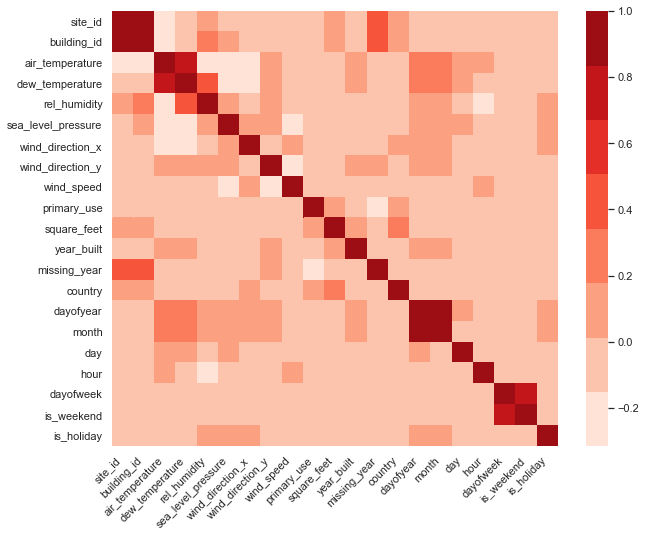

In [38]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap=sns.color_palette('Reds', 8))
plt.xticks(rotation=45, ha='right');

In [39]:
# Drop timestamp and 1 of 2 features from each correlated pair in all 3 sets
to_drop = ['timestamp', 'building_id', 'dew_temperature', 'month', 'dayofweek']
Xe_train.drop(to_drop, axis=1, inplace=True)
Xe_val.drop(to_drop, axis=1, inplace=True)
Xe_test.drop(to_drop, axis=1, inplace=True)

Xe_train.shape, Xe_val.shape, Xe_test.shape

((6888971, 17), (2296324, 17), (2296324, 17))

In [40]:
del corr
gc.collect()

10355

For each of the 4 pairs of corrrelated features, the feature that was dropped is either harder to deal with, harder to understand, or just not as well-suited as the other feature. Features dropped:
- `Building_id` - has much higher cardinality than `site_id`, which makes `site_id` easier to encode
    - Even though `site_id` and `building_id` are numeric, there is no order to the values because these are categorical variables
- `Dew_temperature` - tracks `air_temperature` closely, but is not as concrete conceptually as `air_temperature`
- `Month` - not as fine-tuned as `dayofyear` values, so the model may have a hard time differentiating different days of a month
- `Dayofweek` - not as important to know what day of the week it is as it is to just know whether that day was a weekday or weekend

## Section V: Feature Selection - Electricity Meter

After eliminating redundant features, there are 17 remaining. We will be looking at several feature selection methods to get an idea of which of the 17 features will be the most important in predicting energy consumption.

### Feature scaling

The remaining features are on completely different scales, with boolean features consisting of either 0 or 1 and a feature like `square_feet` containing values in the order of 10 to the 6th power. The values need to be on the same scale so that some of the models (especially linear models) do not misinterpret the data. We will be normalizing the values of every feature with the standard scaling method, where each feature will have a mean of 0 and a standard deviation of 1.

In [41]:
# Scale all features using the mean and standard deviation
scaler = StandardScaler()
scaler.fit(Xe_train)

# Apply the scaler to all 3 sets
Xe_train_scaled = pd.DataFrame(scaler.transform(Xe_train), columns=Xe_train.columns)
Xe_val_scaled = pd.DataFrame(scaler.transform(Xe_val), columns=Xe_val.columns)
Xe_test_scaled = pd.DataFrame(scaler.transform(Xe_test), columns=Xe_test.columns)

Xe_train_scaled.head(3)

,site_id,air_temperature,rel_humidity,sea_level_pressure,wind_direction_x,wind_direction_y,wind_speed,primary_use,square_feet,year_built,missing_year,country,dayofyear,day,hour,is_weekend,is_holiday
0,-1.420122,0.977865,0.741393,-0.120466,1.352629,0.853826,-0.197988,-0.168948,-0.589092,1.827039,-1.108092,-0.044155,0.495444,1.270817,-1.517191,1.577058,-0.180158
1,-0.599999,0.291863,0.562860,0.513359,1.204086,-0.880341,-0.886943,1.204968,-0.238802,2.298373,-1.108092,-0.044155,1.180861,-0.998739,0.938746,-0.634092,-0.180158
2,-0.805030,-1.089669,-0.677575,1.713597,-1.072159,-0.880341,0.447907,-1.080459,2.740196,0.224504,-1.108092,-0.044155,-0.865871,-1.112217,-0.505923,-0.634092,-0.180158


In [42]:
# Save scaler
joblib.dump(scaler, '../models/transformers/scaler/scaler0.pkl')

['../models/transformers/scaler/scaler0.pkl']

### Track how many times each feature is selected

Since we are looking at several methods of selecting features, let's create a table to track the running total of how many times each feature is selected. The idea is that a feature would be a better predictor the more it is selected, and any feature with a count of 0 is probably not contributing very much in the prediction.

In [64]:
# Dataframe to track selection count
feat_sel = pd.DataFrame(zip(Xe_train.columns, [0] * Xe_train.shape[1]))
feat_sel.columns = [None, 'count']
feat_sel.set_index(None, inplace=True)
feat_sel

,count
site_id,0
air_temperature,0
rel_humidity,0
sea_level_pressure,0
wind_direction_x,0
wind_direction_y,0
wind_speed,0
primary_use,0
square_feet,0
year_built,0


### Correlation with target

To start off, let's check the linear correlation of each feature with the target label.

In [65]:
# Merger target variable into the features
e_train = pd.merge(Xe_train, ye_train, how='left', left_index=True, right_index=True)

# Feature correlation with target variable
e_corr = e_train.corr()
e_corr.meter_reading

site_id               0.061445
air_temperature      -0.019610
rel_humidity         -0.028822
sea_level_pressure   -0.016964
wind_direction_x      0.000241
wind_direction_y     -0.009957
wind_speed           -0.006056
primary_use           0.170080
square_feet           0.590750
year_built            0.066943
missing_year         -0.043118
country               0.441936
dayofyear            -0.005081
day                  -0.001361
hour                  0.020725
is_weekend           -0.028242
is_holiday           -0.008945
meter_reading         1.000000
Name: meter_reading, dtype: float64

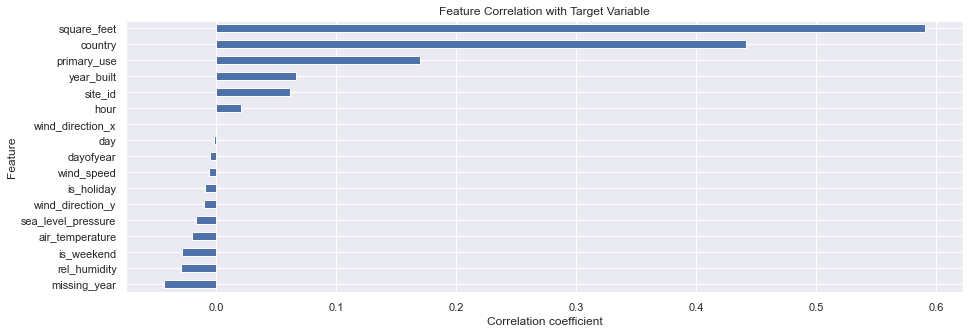

In [66]:
# Plot correlation
e_corr.meter_reading.sort_values()[:-1].plot.barh(figsize=(15, 5), title='Feature Correlation with Target Variable')
plt.ylabel('Feature')
plt.xlabel('Correlation coefficient')
plt.show()

Most of the features have a really low correlation with the target. It looks like `square_feet` and `country` would be the best predictors if we were to use a linear model.

In [67]:
# Add features with a correlation coefficient of at least 0.4
corr_feats = e_corr.query('meter_reading > 0.4').index[:-1].tolist()
feat_sel = udf.inc_feat_count(feat_sel, corr_feats)
feat_sel

,count
site_id,0
air_temperature,0
rel_humidity,0
sea_level_pressure,0
wind_direction_x,0
wind_direction_y,0
wind_speed,0
primary_use,0
square_feet,1
year_built,0


In [68]:
del e_train, e_corr
gc.collect()

9012

### Lasso regularization

Lasso (L1) regularization is able to reduce feature coefficients to 0. This removes the less informative features from the model. Using this selection method, the remaining features are the ones that are "selected". We will be doing this 2 different ways:
1. Select from model - select features with high coefficients
2. Recursive feature eliminaton - recursively remove the feature with the lowest coefficient until half of the features remain

In [ ]:
# Select features using L1 regularization
l1_feats = udf.feats_from_model(Xe_train_scaled, ye_train, SelectFromModel, Lasso())
l1_feats

In [76]:
# Select features recursively using L1 regularization
rfe_l1_feats = udf.feats_from_model(Xe_train_scaled, ye_train, RFE, Lasso(alpha=10))
rfe_l1_feats

['wind_direction_y',
 'wind_speed',
 'primary_use',
 'square_feet',
 'year_built',
 'country',
 'hour',
 'is_weekend']

In [71]:
# Increment the counts of selected features
feat_sel = udf.inc_feat_count(feat_sel, l1_feats + rfe_l1_feats)
feat_sel

,count
site_id,0
air_temperature,0
rel_humidity,0
sea_level_pressure,0
wind_direction_x,0
wind_direction_y,0
wind_speed,0
primary_use,2
square_feet,3
year_built,0


### Tree importance

We'll be repeating the above process with a decision tree model. As decision tree is a nonlinear model, it may provide completely different insights into which features are important in predicting energy consumption.

In [72]:
# Select features using a decision tree
tree_feats = udf.feats_from_model(Xe_train_scaled, ye_train, SelectFromModel, DecisionTreeRegressor())
tree_feats

['site_id', 'square_feet', 'year_built', 'country']

In [ ]:
# Select features recursively using a decision tree
rfe_tree_feats = udf.feats_from_model(Xe_train_scaled, ye_train, RFE, DecisionTreeRegressor())
rfe_tree_feats

In [ ]:
# Increment the counts of selected features
feat_sel = udf.inc_feat_count(feat_sel, tree_feats + rfe_tree_feats)
feat_sel

## Section VI: Featurization Conclusion

### Create dataframe of selected features for each method

In [73]:
# Method names and their selected methods
col = ['lasso_coef', 'lasso_coef_recursive', 'tree_importance', 'tree_importance_recursive']
sel = [l1_feats, rfe_l1_feats, tree_feats, rfe_tree_feats, boosting_feats]

# Selected features for each method
sel_feats = pd.DataFrame(corr_feats, columns=['target_corr'])
for i, s in enumerate(sel):
    sel_feats = pd.merge(sel_feats, pd.DataFrame(s, columns=[col[i]]), how='outer', left_index=True, right_index=True)
sel_feats = sel_feats.fillna('') # fill missing with empty string for readability
sel_feats

,correlation,lasso,lasso_alpha10,lasso_recursive,tree_importance,tree_importance_recursive,gradient_boosting
0,primary_use,building_id,primary_use,dew_temperature,building_id,building_id,building_id
1,square_feet,dew_temperature,square_feet,wind_speed,square_feet,air_temperature,primary_use
2,country,sea_level_pressure,is_weekend,primary_use,year_built,dew_temperature,square_feet
3,,wind_speed,country,square_feet,country,primary_use,year_built
4,,primary_use,,year_built,,square_feet,country
5,,square_feet,,hour,,year_built,
6,,year_built,,wind_direction_y,,dayofyear,
7,,missing_year,,is_weekend,,hour,
8,,dayofyear,,country,,dayofweek,
9,,hour,,is_holiday,,country,


In [74]:
del col, sel, i, s
gc.collect()

22

### Save data

In [75]:
sel_feats.to_csv(f'{path}feats.csv', index=False)
pd.read_csv(f'{path}feats.csv').fillna('')

,correlation,lasso,lasso_alpha10,lasso_recursive,tree_importance,tree_importance_recursive,gradient_boosting
0,primary_use,building_id,primary_use,dew_temperature,building_id,building_id,building_id
1,square_feet,dew_temperature,square_feet,wind_speed,square_feet,air_temperature,primary_use
2,country,sea_level_pressure,is_weekend,primary_use,year_built,dew_temperature,square_feet
3,NaN,wind_speed,country,square_feet,country,primary_use,year_built
4,NaN,primary_use,NaN,year_built,NaN,square_feet,country
5,NaN,square_feet,NaN,hour,NaN,year_built,NaN
6,NaN,year_built,NaN,wind_direction_y,NaN,dayofyear,NaN
7,NaN,missing_year,NaN,is_weekend,NaN,hour,NaN
8,NaN,dayofyear,NaN,country,NaN,dayofweek,NaN
9,NaN,hour,NaN,is_holiday,NaN,country,NaN
